<a href="https://colab.research.google.com/github/PritishWadhwa/DL-Assignments/blob/master/Assignment2/Ques1/CNN_dlAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/dlAssignments/Assignment2/

/content/drive/MyDrive/dlAssignments/Assignment2


In [3]:
ls

CNN_dlAssignment.ipynb  data@


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
plt.style.use('seaborn')
import os
import pathlib
import torch
from torchvision import datasets, transforms
import helper
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from collections import Counter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [5]:
device

device(type='cuda')

In [6]:
# folders = os.listdir("data")
# folders

In [7]:
# path = pathlib.Path('data')
# dirs = path.glob("*")
# imageData = []
# labels = []
# count = {}
# labelDict = {
#     'Parasitized': 0,
#     'Uninfected': 1
# }
# for folder in tqdm(dirs):
#     c = 0
#     label = str(folder).split('/')[-1]
#     count[label] = 0
#     for imgPath in (folder.glob('*.png')):
#         # print(imgPath)
#         c += 1
#         print(c)
#         image = cv2.imread(str(imgPath))
#         count[label] += 1
#         imageData.append(image)
#         labels.append(labelDict[label])
#         # plt.imshow(image)
#         # plt.show()
#         # break

In [8]:
img = Image.open('./data/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_163.png')
img.width, img.height

(148, 208)

In [9]:
dataset = ImageFolder('./data',transform = transforms.Compose([
    transforms.Resize((100,100)),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]))

In [10]:
img, label = dataset[-1]
print(img.shape,label)

torch.Size([3, 100, 100]) 1


In [11]:
dataset.classes

['Parasitized', 'Uninfected']

In [12]:
len(dataset)

27558

In [13]:
trainSize = int(0.8*len(dataset))
valSize = (len(dataset) - trainSize)//2
testSize = len(dataset) - trainSize - valSize

In [14]:
trainData, valData, testData = random_split(dataset, [trainSize, valSize, testSize])

In [15]:
type(dataset), type(trainData)

(torchvision.datasets.folder.ImageFolder, torch.utils.data.dataset.Subset)

In [16]:
trainClasses = [dataset.targets[i] for i in (trainData.indices)]
print('train', Counter(trainClasses))
testClasses = [dataset.targets[i] for i in (testData.indices)]
print('test', Counter(testClasses))
valClasses = [dataset.targets[i] for i in (valData.indices)]
print('val', Counter(valClasses))

train Counter({0: 11044, 1: 11002})
test Counter({0: 1390, 1: 1366})
val Counter({1: 1411, 0: 1345})


In [17]:
len(trainData), len(valData), len(testData)

(22046, 2756, 2756)

In [18]:
trainDataLoader = DataLoader(trainData, 128, shuffle = True, num_workers = 2, pin_memory = True)
testDataLoader = DataLoader(testData, 128, shuffle = True, num_workers = 2, pin_memory = True)
valDataLoader = DataLoader(valData, 128, shuffle = True, num_workers = 2, pin_memory = True)

In [19]:
def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in (dl):
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


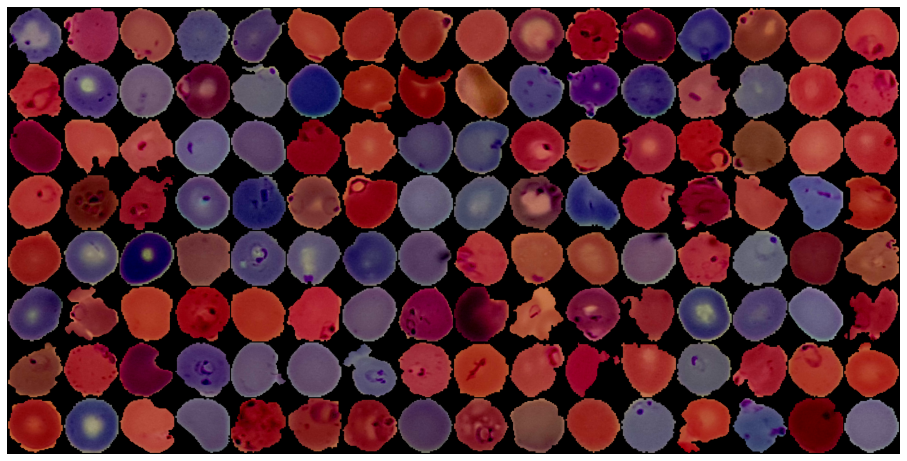

In [20]:
show_batch(trainDataLoader)

In [29]:
class CNN(nn.Module):
    def __init__(self, weightInit='zero'):
        super().__init__()
        self.weight = weightInit
        self.blockA = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=9)
        self.initializeWeights(self.blockA)
        self.blockB = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=6)
        self.initializeWeights(self.blockB)
        self.blockC = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3)
        self.initializeWeights(self.blockC)
        self.maxPool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7776, 100)
        self.initializeWeights(self.fc1)
        self.fc2 = nn.Linear(100, 1)
        self.initializeWeights(self.fc2)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.blockA(x)
        # x = self.relu(x)
        x = self.maxPool(x)
        x = self.blockB(x)
        # x = self.relu(x)
        x = self.maxPool(x)
        x = self.blockC(x)
        # x = self.relu(x)
        # x = self.maxPool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

    def initializeWeights(self, w):
        if self.weight == 'zero':
            nn.init.zeros_(w.weight)
        elif self.weight == 'random':
            nn.init.normal_(w.weight)
        else:
            nn.init.kaiming_normal_(w.weight)
    


In [42]:
cnn = CNN('he').to(device)
# cnn = CNN()

In [43]:
criterion = nn.BCELoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.1)

In [44]:
totalSteps = len(trainDataLoader)
numEpochs = 2
for epoch in range(numEpochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in tqdm(enumerate(trainDataLoader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.reshape((-1, 1)).to(torch.float32).to(device)


        outputs = cnn(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
        if (i+1) % 10 == 0:
            print(f'Epoch {epoch + 1} / {numEpochs}, Step {i+1} / {totalSteps}, Loss: {loss.item():.4f}')

print('Finished Training')

10it [00:04,  2.87it/s]

Epoch 1 / 2, Step 10 / 173, Loss: 48.4375


19it [00:07,  2.60it/s]

Epoch 1 / 2, Step 20 / 173, Loss: 42.1875


30it [00:11,  2.99it/s]

Epoch 1 / 2, Step 30 / 173, Loss: 47.6562


40it [00:15,  2.97it/s]

Epoch 1 / 2, Step 40 / 173, Loss: 46.8750


49it [00:19,  2.66it/s]

Epoch 1 / 2, Step 50 / 173, Loss: 37.5000


59it [00:22,  2.67it/s]

Epoch 1 / 2, Step 60 / 173, Loss: 45.3125


69it [00:26,  2.66it/s]

Epoch 1 / 2, Step 70 / 173, Loss: 43.7500


79it [00:30,  2.69it/s]

Epoch 1 / 2, Step 80 / 173, Loss: 42.9688


89it [00:34,  2.66it/s]

Epoch 1 / 2, Step 90 / 173, Loss: 51.5625


99it [00:37,  2.66it/s]

Epoch 1 / 2, Step 100 / 173, Loss: 50.0000


109it [00:41,  2.67it/s]

Epoch 1 / 2, Step 110 / 173, Loss: 35.9375


119it [00:45,  2.66it/s]

Epoch 1 / 2, Step 120 / 173, Loss: 50.7812


129it [00:49,  2.64it/s]

Epoch 1 / 2, Step 130 / 173, Loss: 51.5625


139it [00:52,  2.68it/s]

Epoch 1 / 2, Step 140 / 173, Loss: 54.6875


149it [00:56,  2.68it/s]

Epoch 1 / 2, Step 150 / 173, Loss: 43.7500


159it [01:00,  2.65it/s]

Epoch 1 / 2, Step 160 / 173, Loss: 46.8750


169it [01:04,  2.69it/s]

Epoch 1 / 2, Step 170 / 173, Loss: 53.1250


173it [01:04,  2.66it/s]
10it [00:03,  2.96it/s]

Epoch 2 / 2, Step 10 / 173, Loss: 41.4062


20it [00:07,  2.97it/s]

Epoch 2 / 2, Step 20 / 173, Loss: 35.9375


29it [00:11,  2.58it/s]

Epoch 2 / 2, Step 30 / 173, Loss: 50.0000


39it [00:15,  2.75it/s]

Epoch 2 / 2, Step 40 / 173, Loss: 40.6250


50it [00:19,  3.12it/s]

Epoch 2 / 2, Step 50 / 173, Loss: 47.6562


60it [00:22,  3.08it/s]

Epoch 2 / 2, Step 60 / 173, Loss: 48.4375


69it [00:26,  2.65it/s]

Epoch 2 / 2, Step 70 / 173, Loss: 47.6562


79it [00:30,  2.72it/s]

Epoch 2 / 2, Step 80 / 173, Loss: 46.8750


89it [00:33,  2.67it/s]

Epoch 2 / 2, Step 90 / 173, Loss: 47.6562


99it [00:37,  2.71it/s]

Epoch 2 / 2, Step 100 / 173, Loss: 50.7812


109it [00:41,  2.71it/s]

Epoch 2 / 2, Step 110 / 173, Loss: 50.7812


119it [00:44,  2.70it/s]

Epoch 2 / 2, Step 120 / 173, Loss: 53.9062


129it [00:48,  2.70it/s]

Epoch 2 / 2, Step 130 / 173, Loss: 46.8750


140it [00:52,  3.11it/s]

Epoch 2 / 2, Step 140 / 173, Loss: 43.7500


149it [00:56,  2.59it/s]

Epoch 2 / 2, Step 150 / 173, Loss: 54.6875


159it [00:59,  2.66it/s]

Epoch 2 / 2, Step 160 / 173, Loss: 39.0625


169it [01:03,  2.61it/s]

Epoch 2 / 2, Step 170 / 173, Loss: 41.4062


173it [01:04,  2.68it/s]

Finished Training


In [48]:
with torch.no_grad():
    nCorrect = 0
    nSamples = 0
    nClassCorrect = [0 for i in range(2)]
    nClassTotal = [0 for i in range(2)]
    for data in testDataLoader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.reshape((-1, 1)).to(torch.float32).to(device)

        outputs = cnn(inputs)
        #value, index
        _, predictions = torch.max(outputs, 1)
        nSamples += labels.shape[0]
        # nCorrect += (predictions == labels).sum().item()
        for i in range(len(predictions)):
            if predictions[i] == labels[i]:
                nCorrect += 1
        # for i in range(128):
        #     label = labels[i]
        #     pred = predictions[i]
        #     nClassCorrect[label] += (pred == label).item()
        #     nClassTotal[label] += 1
    acc = 100.0 * nCorrect / nSamples
    print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    # for i in range(2):
    #     print(f'Accuracy of {i} : {100.0 * nClassCorrect[i] / nClassTotal[i]:.2f}%')

Accuracy of the network on the 10000 test images: 50.44%


In [49]:
with torch.no_grad():
    nCorrect = 0
    nSamples = 0
    nClassCorrect = [0 for i in range(2)]
    nClassTotal = [0 for i in range(2)]
    for data in valDataLoader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.reshape((-1, 1)).to(torch.float32).to(device)

        outputs = cnn(inputs)
        #value, index
        _, predictions = torch.max(outputs, 1)
        nSamples += labels.shape[0]
        # nCorrect += (predictions == labels).sum().item()
        for i in range(len(predictions)):
            if predictions[i] == labels[i]:
                nCorrect += 1
        # for i in range(128):
        #     label = labels[i]
        #     pred = predictions[i]
        #     nClassCorrect[label] += (pred == label).item()
        #     nClassTotal[label] += 1
    acc = 100.0 * nCorrect / nSamples
    print(f'Accuracy of the network on the 10000 test images: {acc:.2f}%')
    # for i in range(2):
    #     print(f'Accuracy of {i} : {100.0 * nClassCorrect[i] / nClassTotal[i]:.2f}%')

Accuracy of the network on the 10000 test images: 48.80%


In [ ]:
len(predictions), len(labels), nCorrect, nSamples, (predictions == labels).sum().item()

(68, 68, 174900, 2756, 1972)

In [ ]:
c = 0
for i in range(len(predictions)):
    if predictions[i] == labels[i]:
        c += 1
c

29

In [ ]:
predictions

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

In [ ]:
labels

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testDataLoader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.reshape((-1, 1)).to(torch.float32).to(device)
        # calculate outputs by running images through the network
        outputs = cnn(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 6341 %


In [ ]:
correct

174780

In [ ]:
total

2756

In [ ]:
outputs.shape, labels.shape

(torch.Size([128, 1]), torch.Size([128, 1]))

In [ ]:
labels = labels.reshape((128,1))

In [ ]:
type(labels[0])

torch.Tensor

In [ ]:
labels[0].dtype

torch.int64

In [ ]:
outputs[0].dtype

torch.float32

In [ ]:
outputs[0]

tensor([0.5121], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
labels = labels.to(torch.float32)

In [ ]:
testLabels = 0
for i in tqdm(testData):
    testLabels += i[1]
testLabels

  2%|▏         | 47/2756 [00:11<11:05,  4.07it/s]


KeyboardInterrupt: ignored

In [ ]:
trainLabels = 0
valLabels = 0
testLabels = 0
for i in tqdm(trainData):
    trainLabels += i[1]
for i in valData:
    valLabels += i[1]
for i in testData:
    testLabels += i[1]
trainLabels, valLabels, testLabels

 17%|█▋        | 3793/22046 [17:16<1:23:06,  3.66it/s]


KeyboardInterrupt: ignored

In [ ]:
trainLoader = DataLoader(trainData, batch_size=1, num_workers=0, shuffle=True)

In [ ]:
trainLabels = 0
for step, (x, y) in tqdm(enumerate(trainLoader)):
    trainLabels += y

50it [00:14,  3.49it/s]


KeyboardInterrupt: ignored

In [ ]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

Label : Uninfected


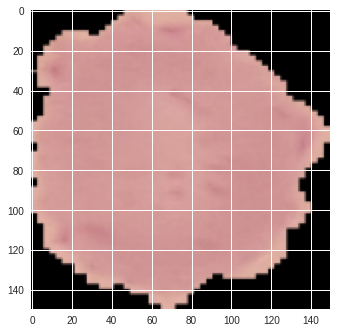

In [ ]:
display_img(*dataset[-1])

In [ ]:
cv2.imread('data/Parasitized/C91P52ThinF_IMG_20150821_125256_cell_4.png')

array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[162, 177, 216],
        [161, 178, 217],
        [161, 178, 217],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [ ]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
# transform = transforms.Compose([transforms.Resize(255),transforms.ToTensor()])

In [ ]:
dataset = datasets.ImageFolder('data', transform=transform)

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
def imshow(image, ax=None, title=None, normalize=True):
  """Imshow for Tensor."""
  if ax is None:
      fig, ax = plt.subplots()
  image = image.numpy().transpose((1, 2, 0))

  if normalize:
      mean = np.array([0.485, 0.456, 0.406])
      std = np.array([0.229, 0.224, 0.225])
      image = std * image + mean
      image = np.clip(image, 0, 1)

  ax.imshow(image)
  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.tick_params(axis='both', length=0)
  ax.set_xticklabels('')
  ax.set_yticklabels('')

  return ax

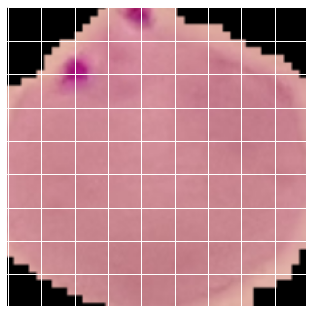

In [ ]:
images, labels = next(iter(dataloader))
imshow(images[0], normalize=False)

In [ ]:
helper.imshow(dataset[0], normalize=False)


AttributeError: ignored

In [ ]:
cd data

/content/drive/.shortcut-targets-by-id/15bq-XlNJT4oXrmSycUNcRCO-SG71cV-g/data
